# Policy Evaluation and Optimization

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

import sys
from utils import *

## Config

In [2]:
CONFIG = {
    'env':{
        'desc': None,
        'lake_size': 4,
        'is_slippery': True,
    },
    'policy_eval':{
        'gamma': 0.99,
        'threshold': 1e-6,
    },
    'policy_iter':{
        'gamma': 0.99,
        'threshold': 1e-6,
    },
    'value_iter_sync':{
        'gamma': 0.99,
        'threshold': 1e-6,
    },
    'value_iter_async':{
        'gamma': 0.99,
        'threshold': 1e-6,
    },
    'animation':{
        'FPS': 15,
        'do_truncate': False,
    },
    'print_policy_thresh': 1e-6,
}

## Creating the FrozenLake env

In [3]:
lake_size = CONFIG['env']['lake_size']
lake_shape = (lake_size,lake_size)
env = gym.make('FrozenLake-v1',
               desc= CONFIG['env']['desc'], 
               map_name= "8x8" if lake_size == 8 else "4x4",
               is_slippery= CONFIG['env']['is_slippery'], 
               render_mode= "rgb_array")

## Helper functions

In [4]:
def print_policy(policy: np.ndarray, V: np.ndarray, shape: tuple([int,int]) = (4, 4), threshold: float = 1e-5):
    '''
    Visualizes a given deterministic policy using arrows

    Args:
        policy (np.ndarray): Array of size [S x A] representing the policy
        V (np.ndarray): Array of length S representing the value function
        shape (tuple[int,int]): Shape of the environment
        threshold (float): The threshold value under which states are classified as terminal based on V
    '''
    if shape[0] == 4:
        print(f"== Policy ==")
    else:
        print(f"======= Policy ========")
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    for i in range(shape[0]):
        row = ""
        for j in range(shape[1]):
            s = i * shape[1] + j
            if V[s] < threshold:
                row += " . "   
            else:
                row += f" {action_symbols[policy[s]]} "
        print(row)

## Policy Evaluation

In [5]:
def policy_evaluation(env, policy: np.ndarray, gamma: float = 1.0, threshold: float = 1e-4):

    '''
    Evaluates the value function of the given policy

    Args:
        env: OpenAI Env
        policy (np.ndarray): [S, A] shaped matrix representing the policy.
        gamma (float): The discount factor
        threshold (float): We stop when the value function change is less than the threshold for all states.

    Returns:
        np.array of length S representing the value function.
    '''

    nS = env.observation_space.n
    nA = env.action_space.n
    P = env.unwrapped.P

    V = np.zeros((nS))

    iteration = 0
    while True:

        iteration += 1
        if iteration %10 == 0:
            print(f"\rIteration : {iteration}",end='')
        sys.stdout.flush()
        
        delta = 0
        for s in range(nS):
            value_sum = 0
            for a in range(nA):
                for prob, next_s, reward, done in P[s][a]:
                    if done:
                        value_sum += policy[s,a]*prob*reward
                    else:
                        value_sum += policy[s,a]*prob*(reward + gamma*V[next_s])

            delta = max(delta, abs(V[s] - value_sum))
            V[s] = value_sum
            
        if delta < threshold:
            break

    return V

Iteration : 30

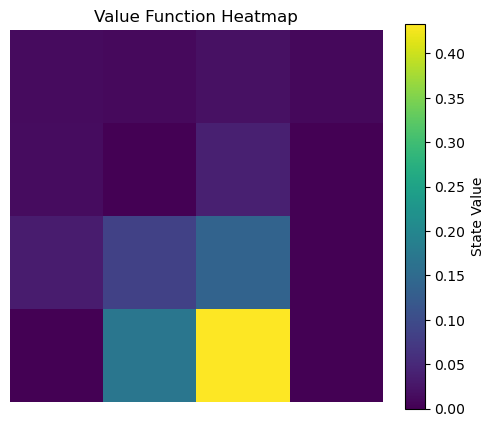

In [6]:
random_policy = np.ones((env.observation_space.n,env.action_space.n))/env.action_space.n

V = policy_evaluation(env, random_policy, **CONFIG['policy_eval'])

V = V.reshape(lake_shape)

plt.figure(figsize=(6, 5))
heatmap = plt.imshow(V, cmap='viridis', origin='upper')  # you can change the colormap
plt.axis('off')
plt.colorbar(heatmap, label='State Value')
plt.title('Value Function Heatmap')
plt.show()

## Policy Iteration

In [7]:
def policy_iteration(env, gamma: float = 1.0, threshold: float = 1e-4):
    '''
    Finds optimal policy and value function via policy iteration

    Args:
        env: OpenAI Env
        gamma (float): The discount factor
        threshold (float): We stop when the value function change is less than the threshold for all states.

    Returns:
        np.ndarray of size [S x A] representing the policy.
        np.array of length S representing the value function.
    '''
    
    nS = env.observation_space.n
    nA = env.action_space.n
    P = env.unwrapped.P

    def get_greedy_policy(V):
        '''
        Returns the greedy policy for a given value function V

        Args:
            V (np.ndarray): np.array of length S representing the value function

        Returns:
            np.ndarray of size [S x A] representing the greedy policy.
        '''
        
        greedy_policy = np.zeros((nS,nA))
        for s in range(nS):
            A = np.zeros(nA)
            for a in range(nA):
                for prob, next_s, reward, done in P[s][a]:
                    A[a] += prob*(reward + gamma*V[next_s])
                    
            greedy_policy[s, np.argmax(A)] = 1.0
        return greedy_policy
                
    policy = np.ones((nS,nA))/nA
    V = np.zeros(nS)
    
    iteration = 0
    while True:
        
        iteration += 1
        if iteration %10 == 0:
            print(f"\rIteration : {iteration}",end='')
        sys.stdout.flush()

        V = policy_evaluation(env, policy, gamma, threshold)
        new_policy = get_greedy_policy(V)
        
        if np.array_equal(policy, new_policy):
            break
        policy = new_policy
        
    return policy, V

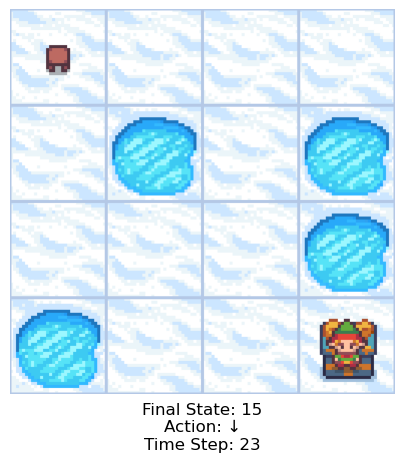

== Policy ==
 ←  ↑  ↑  ↑ 
 ←  .  ←  . 
 ↑  ↓  ←  . 
 .  →  ↓  . 


In [8]:
policy, V = policy_iteration(env, **CONFIG['policy_iter'])

plots.animate_policy(env, policy, **CONFIG['animation'])

print_policy(policy = np.argmax(policy, axis=1), V = V,
             shape = lake_shape, threshold = CONFIG['print_policy_thresh'])

## Synchronous Value Iteration

In [9]:
def value_iteration_sync(env, gamma: float = 1.0, threshold: float = 1e-4):

    '''
    Finds optimal policy and value function via synchronous value iteration

    Args:
        env: OpenAI Env
        gamma (float): The discount factor
        threshold (float): We stop when the value function change is less than the threshold for all states.

    Returns:
        np.ndarray of size [S x A] representing the policy.
        np.array of length S representing the value function.
    '''

    def get_greedy_policy(V):
        '''
        Returns the greedy policy for a given value function V

        Args:
            V (np.ndarray): np.array of length S representing the value function

        Returns:
            np.ndarray of size [S x A] representing the greedy policy.
        '''
        
        greedy_policy = np.zeros((nS,nA))
        for s in range(nS):
            A = np.zeros(nA)
            for a in range(nA):
                for prob, next_s, reward, done in P[s][a]:
                    A[a] += prob*(reward + gamma*V[next_s])
                    
            greedy_policy[s, np.argmax(A)] = 1.0
        return greedy_policy
    
    nS = env.observation_space.n
    nA = env.action_space.n
    P = env.unwrapped.P

    V = np.zeros(nS)
    V_new = np.zeros(nS)
    
    iteration = 0
    while True:

        iteration += 1
        if iteration %10 == 0:
            print(f"\rIteration : {iteration}",end='')
        sys.stdout.flush()
        
        delta = 0
        for s in range(nS):

            A = np.zeros(nA)
            
            for a in range(nA):
                for prob, next_s, reward, done in P[s][a]:
                    if done:
                        A[a] += prob*reward
                    else:
                        A[a] += prob*(reward + gamma*V[next_s])

            delta = max(delta, abs(V[s] - np.max(A)))
            V_new[s] = np.max(A)
            
        if delta < threshold:
            break
            
        V = V_new

    return get_greedy_policy(V), V

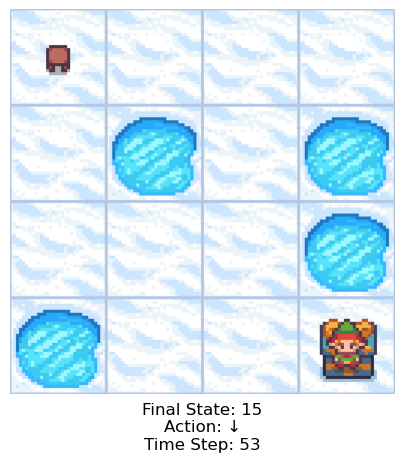

== Policy ==
 ←  ↑  ↑  ↑ 
 ←  .  ←  . 
 ↑  ↓  ←  . 
 .  →  ↓  . 


In [10]:
policy, V = value_iteration_sync(env, **CONFIG['value_iter_sync'])

plots.animate_policy(env, policy, **CONFIG['animation'])

print_policy(policy = np.argmax(policy, axis=1), V = V,
             shape = lake_shape, threshold = CONFIG['print_policy_thresh'])

## Asynchronous Value Iteration

In [11]:
def value_iteration_async(env, gamma: float = 1.0, threshold: float = 1e-4):
    '''
    Finds optimal policy and value function via asynchronous value iteration

    Args:
        env: OpenAI Env
        gamma (float): The discount factor
        threshold (float): We stop when the value function change is less than the threshold for all states.

    Returns:
        np.ndarray of size [S x A] representing the policy.
        np.array of length S representing the value function.
    '''

    def get_greedy_policy(V: np.ndarray):
        '''
        Returns the greedy policy for a given value function V

        Args:
            V (np.ndarray): np.array of length S representing the value function

        Returns:
            np.ndarray of size [S x A] representing the greedy policy.
        '''
        
        greedy_policy = np.zeros((nS,nA))
        for s in range(nS):
            A = np.zeros(nA)
            for a in range(nA):
                for prob, next_s, reward, done in P[s][a]:
                    A[a] += prob*(reward + gamma*V[next_s])
                    
            greedy_policy[s, np.argmax(A)] = 1.0
        return greedy_policy
    
    nS = env.observation_space.n
    nA = env.action_space.n
    P = env.unwrapped.P

    V = np.zeros(nS)
    
    iteration = 0
    while True:

        iteration += 1
        if iteration %10 == 0:
            print(f"\rIteration : {iteration}",end='')
        sys.stdout.flush()
        
        delta = 0
        for s in range(nS):

            A = np.zeros(nA)
            
            for a in range(nA):
                for prob, next_s, reward, done in P[s][a]:
                    if done:
                        A[a] += prob*reward
                    else:
                        A[a] += prob*(reward + gamma*V[next_s])

            delta = max(delta, abs(V[s] - np.max(A)))
            V[s] = np.max(A)
            
        if delta < threshold:
            break

    return get_greedy_policy(V), V

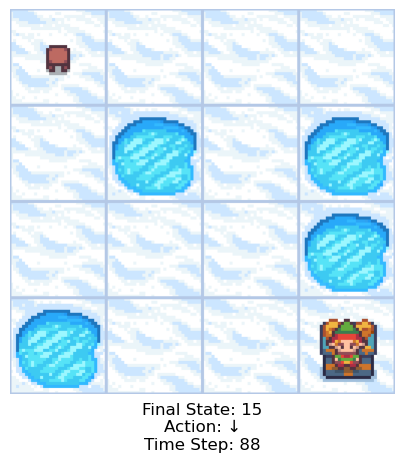

== Policy ==
 ←  ↑  ↑  ↑ 
 ←  .  ←  . 
 ↑  ↓  ←  . 
 .  →  ↓  . 


In [12]:
policy, V = value_iteration_async(env, **CONFIG['value_iter_async'])

plots.animate_policy(env, policy, **CONFIG['animation'])

print_policy(policy = np.argmax(policy, axis=1), V = V,
             shape = lake_shape, threshold = CONFIG['print_policy_thresh'])